# Introduction to Deep Learning 67822 - [Ex3](https://docs.google.com/document/d/12ZI1Q5cpf2aClCAIB5Tr4hcF0gLowrVbG7cNWXoHFpY/edit?pli=1&tab=t.0)

## **Programing Task:** Sentiment Analysis for the IMDB Movies Reviews Dataset

The dataset consists of 50,000 annotated reviews. Each review is a plain text describing the viewers’ experience and opinion on the movie watched. The dataset consists of highly polar reviews and contains binary labels (positive and negative) based on the number of stars the movie received by the viewers. Some reviews are very long, but we will consider only the first 100 words they contain.

In this exercise we design networks that predict the viewers’ sentiment (positive/negative) towards the movies they watched based on the review they wrote. We will compare the following four different strategies:

1. The use of a simple Elman RNN  
2. The use of a simple GRU  
3. The use of a global average pooling. In this case every word goes through an MLP that result in a scalar, we call “*sub-prediction score”*, and these scores are then summed together to provide the final prediction  
4. Adding a local self-attention layer to Strategy \#3 in order to achieve crossword reasoning (contextualization)

The exercise comes with a partial code that loads the reviews from the dataset, and processes them into a long list of lower-case text (100 words, no punctuation/sentences, no special characters). Longer reviews are truncated, shorter ones are padded. This pre-processing uses the GloVe word embedding which maps every word into a 100-dimensional vector. To avoid over-fitting over this small dataset we do not allow this embedding to train; treat it as a frozen part of the model. You can read more about this embedding [here](https://nlp.stanford.edu/projects/glove/). Some parts of these pre-processing steps were taken from [this](https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/) tutorial.

The exercise consists of the following specific tasks. 

### Setup

#### Logs Directory Setup

In [1]:
import os
# Create directories for organized output
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True) 
os.makedirs("logs", exist_ok=True)

#### Imports

In [2]:
import torch as tr
import torch
from torch.nn.functional import pad
import torch.nn as nn
import numpy as np
import loader as ld

# CODE_CHANGE: Importing visualization module + Importing loader modules
################################################
from viz import plot_losses_and_accuracy
from loader import embedding_size, device, MAX_LENGTH, preprocess_review, tokinize, device
################################################

#### Setting up constants

In [3]:
batch_size = 32
output_size = 2
hidden_size = 64        # to experiment with

# CODE_CHANGE: I moved those flags to the training function
"""################################################
run_recurrent = True    # else run Token-wise MLP
use_RNN = True          # otherwise GRU
atten_size = 0          # atten > 0 means using restricted self atten
################################################"""

reload_model = False
num_epochs = 10
learning_rate = 0.001
test_interval = 50

#### getting IMDB dataset

In [4]:
# Loading sataset, use toy = True for obtaining a smaller dataset
train_dataset, test_dataset, num_words, input_size = ld.get_data_set(batch_size)

#### General Training/testing wrapper function based of `sentiment_start.py`

In [5]:
# CODE_CHANGE: Wrapped all the given training code in a function
################################################
def train_model(model, model_name, train_dataset, test_dataset, num_words, criterion, optimizer, run_recurrent, use_RNN, use_MLP, atten_size):
################################################

    # CODE_CHANGE: Added an accuracy and loss logger
    ################################################
    result_logger = []
    train_acc = 0.5
    test_acc = 0.5
    ################################################

    # CODE_CHANGE: Added code for saving the model text output.
    ################################################
    with open(f"logs/models_log.txt", "a") as f:
        log_text = (f"Running model: {model_name}")
        f.write(log_text + "\n")
    ################################################

    train_loss = 1.0
    test_loss = 1.0

    for epoch in range(num_epochs):

        itr = 0 # iteration counter within each epoch

        for labels, reviews, reviews_text in train_dataset:   # getting training batches

            itr = itr + 1

            if (itr + 1) % test_interval == 0:
                test_iter = True
                labels, reviews, reviews_text = next(iter(test_dataset)) # get a test batch 
            else:
                test_iter = False

            # Recurrent nets (RNN/GRU)

            if run_recurrent:
                hidden_state = model.init_hidden(int(labels.shape[0]))

                for i in range(num_words):
                    output, hidden_state = model(reviews[:,i,:], hidden_state)  # HIDE

            else:  

            # Token-wise networks (MLP / MLP + Atten.) 
            
                sub_score = []
                if use_MLP:
                    # calculate MLP prediction :
                    # output: [positive sentence probability,
                    #          negative sentence probability]
                    # sub_score: [positive word probability,
                    #               negative word probability]
                    output, sub_score = model(reviews)
                elif atten_size > 0:                
                    # MLP + atten
                    sub_score, atten_weights = model(reviews)
                    output = torch.mean(sub_score, dim=1)  # Need to compute output for attention case

                else:
                     raise ValueError("Invalid configuration: Please enable one of use_MLP / atten_size / run_recurrent")
                # In original code mean calculation for sub_score was here
                
            # cross-entropy loss

            loss = criterion(output, labels)

            # CODE_CHANGE: Added accuracy calculation
            ################################################
            with torch.no_grad():
                actual = torch.argmax(labels, dim=1)
                predicted = torch.argmax(output, dim=1)
                correct = (predicted == actual).float().sum()
                accuracy = correct / labels.size(0)
            ################################################
            # optimize in training iterations

            if not test_iter:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # averaged losses
            if test_iter:
                test_loss = 0.8 * float(loss.detach()) + 0.2 * test_loss

                # CODE_CHANGE: Update accuracy
                ################################################
                test_acc = 0.8 * float(accuracy) + 0.2 * test_acc
                ################################################

            else:
                train_loss = 0.9 * float(loss.detach()) + 0.1 * train_loss

                # CODE_CHANGE: Update accuracy
                ################################################
                train_acc = 0.9 * float(accuracy) + 0.1 * train_acc
                ################################################
            if test_iter:

                # CODE_CHANGE:
                # Moved this printing code to the end of epoch loop
                # in order to print only per epoch for more clarity.
                # the data per interval is still logged to a file,
                # and will be shown in the plots.
                ################################################
                """
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}], "
                    f"Step [{itr + 1}/{len(train_dataset)}], "
                    f"Train Loss: {train_loss:.4f}, "
                    f"Test Loss: {test_loss:.4f}"
                )
                """
                ################################################


                # CODE_CHANGE: Added code for saving the model text output.
                ################################################
                with open(f"logs/models_log.txt", "a") as f:
                    log_text = (
                        f"Epoch [{epoch + 1}/{num_epochs}] | "
                        f"Step [{itr + 1}/{len(train_dataset)}] | "
                        f"Train Loss: {train_loss:.4f} | "
                        f"Test Loss: {test_loss:.4f} | "
                        f"Train Acc: {train_acc:.4f} | "
                        f"Test Acc: {test_acc:.4f}"
                    )
                    f.write(log_text + "\n")
                ################################################
                

                # CODE_CHANGE: Added code to log the losses and accuracies
                ################################################
                result_logger.append({
                    'epoch': epoch + 1,
                    'step': itr + 1,
                    'train_loss': train_loss,
                    'test_loss': test_loss,
                    'train_acc': train_acc,
                    'test_acc': test_acc
                })
                ################################################


                if not run_recurrent:
                    nump_subs = sub_score.detach().numpy()
                    labels = labels.detach().numpy()
                    # print_review(reviews_text[0], nump_subs[0,:,0], nump_subs[0,:,1], labels[0,0], labels[0,1])
                
                # saving the model
                # CODE_CHANGE: dded code to save the model in a specific folder
                ################################################
                torch.save(model.state_dict(), f"models/{model_name}.pth")
                ################################################

        
        # CODE_CHANGE:
        # printing code is now in the end of the epoch loop
        # instead of per interval, for more clarity.
        # it also print accuracies now.
        ################################################         
        print(
            f"Epoch [{epoch + 1}/{num_epochs}] | "
            f"Step [{itr}/{len(train_dataset)}] | "
            f"Train Loss: {train_loss:.4f} | "
            f"Test Loss: {test_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Test Acc: {test_acc:.4f}"
        )
        ################################################


    # CODE_CHANGE: returning losses and accuracies logger
    ################################################
    return result_logger
    ################################################


### 1.
Fill in the missing lines of code in the `RNN` and `GRU` cells functions.

The `RNN` contains some lines which you may find helpful (or choose to omit and implement on your own).

The gates and update operators should consist of a single FC layer (hidden state dim. should be between 64-128 for the lowest test error).

The convention of the tensors for these recurrent networks is $N_{batch}$ x $N_{word}$ x $N_{features}$, or **batch element x “time index” x feature vector coordinate**. So the recurrence (your iteration in the code) should apply and advance on the second axis.

Once the review is parsed, its hidden-state should pass through an MLP which produces the final output sentiment prediction (a 2-class one hot vector). Do not use a single output sentiment scalar for reasons that we will see below.

Run each of these recurrent network architectures, describe your experiments with two different hidden-state dimensions (small/large),and the train/test accuracies obtained (with plots).

Explain what could lead to the different results you found in the experiment (both `RNN` vs `GRU` and hidden state size). Come up with a test review of your own that demonstrates the different capabilities of the two recurrent models. 

Add this review (and maybe variations of it that you’ve experimented with), and the results obtained and your explanation to the report.

**Add to your PDF the code lines where you combine input with hidden state and apply the activation function in your `RNN`. In addition, add the lines that compute the reset gate and update gate in the `GRU`**

#### `RNN` Class Implementation

In [6]:
# Implements RNN Unit
class ExRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExRNN, self).__init__()

        self.hidden_size = hidden_size
        self.sigmoid = torch.sigmoid

        # RNN Cell weights
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        # CODE_CHANGE: what else?
        ##################################################
        self.out = nn.Linear(hidden_size, output_size)
        ##################################################


    def name(self):
        return "RNN"

    def forward(self, x, hidden_state):

        # CODE_CHANGE: Implementation of RNN cell
        ##################################################
        # Concatenate input and hidden state
        combined = torch.cat((x, hidden_state), dim=1)  # Shape: (batch_size, input_size + hidden_size)

        # Apply linear transformation + tanh activation
        hidden = torch.tanh(self.in2hidden(combined))  # Updated hidden state

        output = self.out(hidden)  # final sentiment prediction
        ##################################################
        return output, hidden

    def init_hidden(self, bs):
        return torch.zeros(bs, self.hidden_size)

#### `GRU` Class Implementation

In [7]:
# Implements GRU Unit
class ExGRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExGRU, self).__init__()
        self.hidden_size = hidden_size
        # GRU Cell weights
        # self.something =
        # etc ...

        # CODE_CHANGE: Initialize GRU Cell weights
        ##################################################
        self.W_z = nn.Linear(input_size + hidden_size, hidden_size)  # update gate
        self.W_r = nn.Linear(input_size + hidden_size, hidden_size)  # reset gate
        self.W_h = nn.Linear(input_size + hidden_size, hidden_size)  # candidate hidden
        self.out = nn.Linear(hidden_size, output_size)
        ##################################################

    def name(self):
        return "GRU"

    def forward(self, x, hidden_state):
        # CODE_CHANGE: Implementation of GRU cell
        ##################################################
        # missing implementation
        combined = torch.cat((x, hidden_state), dim=1)

        # GRU gates
        z = torch.sigmoid(self.W_z(combined))     # update gate
        r = torch.sigmoid(self.W_r(combined))     # reset gate

        # candidate hidden state uses reset-applied hidden
        combined_reset = torch.cat((x, r * hidden_state), dim=1)
        h_tilde = torch.tanh(self.W_h(combined_reset))

        # final hidden state
        hidden = (1 - z) * hidden_state + z * h_tilde

        output = self.out(hidden)  # final sentiment prediction
        ##################################################
        return output, hidden

    def init_hidden(self, bs):
        return torch.zeros(bs, self.hidden_size)

#### Comparing `RNN` vs `GRU` with 64/128 hidden sizes

Running model: Q1_ExRNN_hidden64
Epoch [1/10] | Step [938/938] | Train Loss: 0.6439 | Test Loss: 0.7029 | Train Acc: 0.5605 | Test Acc: 0.4967
Epoch [2/10] | Step [938/938] | Train Loss: 0.6924 | Test Loss: 0.6744 | Train Acc: 0.6120 | Test Acc: 0.5621
Epoch [3/10] | Step [938/938] | Train Loss: 0.7016 | Test Loss: 0.6472 | Train Acc: 0.5110 | Test Acc: 0.6544
Epoch [4/10] | Step [938/938] | Train Loss: 0.6617 | Test Loss: 0.6422 | Train Acc: 0.6707 | Test Acc: 0.6267
Epoch [5/10] | Step [938/938] | Train Loss: 0.6584 | Test Loss: 0.6887 | Train Acc: 0.5629 | Test Acc: 0.4565
Epoch [6/10] | Step [938/938] | Train Loss: 0.7132 | Test Loss: 0.6817 | Train Acc: 0.5642 | Test Acc: 0.6313
Epoch [7/10] | Step [938/938] | Train Loss: 0.6758 | Test Loss: 0.6697 | Train Acc: 0.5546 | Test Acc: 0.6977
Epoch [8/10] | Step [938/938] | Train Loss: 0.8609 | Test Loss: 0.6473 | Train Acc: 0.1677 | Test Acc: 0.6112
Epoch [9/10] | Step [938/938] | Train Loss: 0.6904 | Test Loss: 0.6948 | Train Acc: 0.5

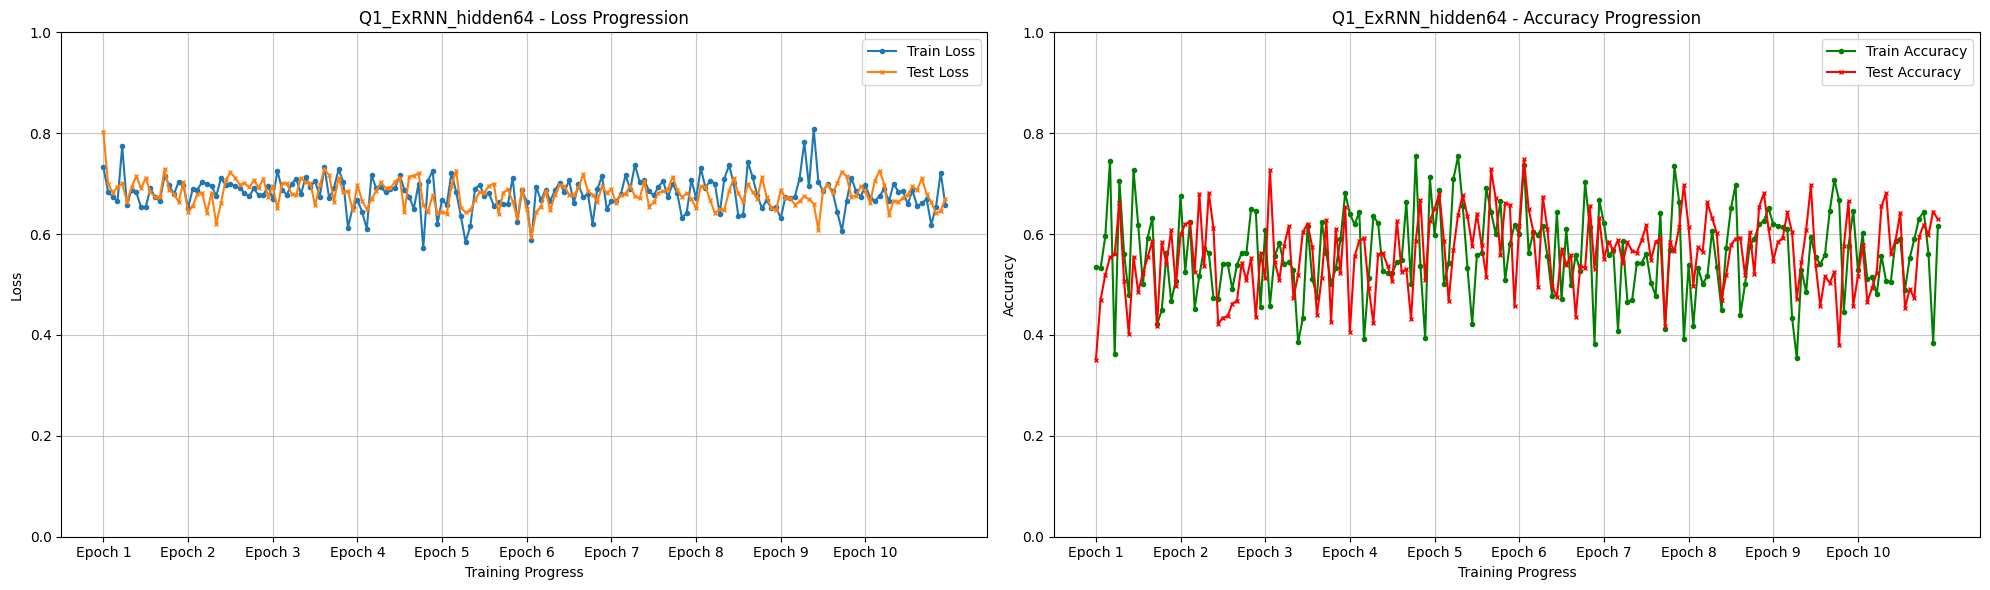

Running model: Q1_ExGRU_hidden64
Epoch [1/10] | Step [938/938] | Train Loss: 0.4238 | Test Loss: 0.3416 | Train Acc: 0.8185 | Test Acc: 0.8512
Epoch [2/10] | Step [938/938] | Train Loss: 0.3278 | Test Loss: 0.3386 | Train Acc: 0.9168 | Test Acc: 0.8437
Epoch [3/10] | Step [938/938] | Train Loss: 0.4674 | Test Loss: 0.3734 | Train Acc: 0.7624 | Test Acc: 0.8295
Epoch [4/10] | Step [938/938] | Train Loss: 0.3426 | Test Loss: 0.4672 | Train Acc: 0.8134 | Test Acc: 0.8117
Epoch [5/10] | Step [938/938] | Train Loss: 0.5773 | Test Loss: 0.4087 | Train Acc: 0.7575 | Test Acc: 0.8263
Epoch [6/10] | Step [938/938] | Train Loss: 0.4248 | Test Loss: 0.2055 | Train Acc: 0.8773 | Test Acc: 0.9479
Epoch [7/10] | Step [938/938] | Train Loss: 0.2524 | Test Loss: 0.4319 | Train Acc: 0.9284 | Test Acc: 0.7735
Epoch [8/10] | Step [938/938] | Train Loss: 0.2969 | Test Loss: 0.3215 | Train Acc: 0.8137 | Test Acc: 0.7750
Epoch [9/10] | Step [938/938] | Train Loss: 0.1211 | Test Loss: 0.2067 | Train Acc: 0.9

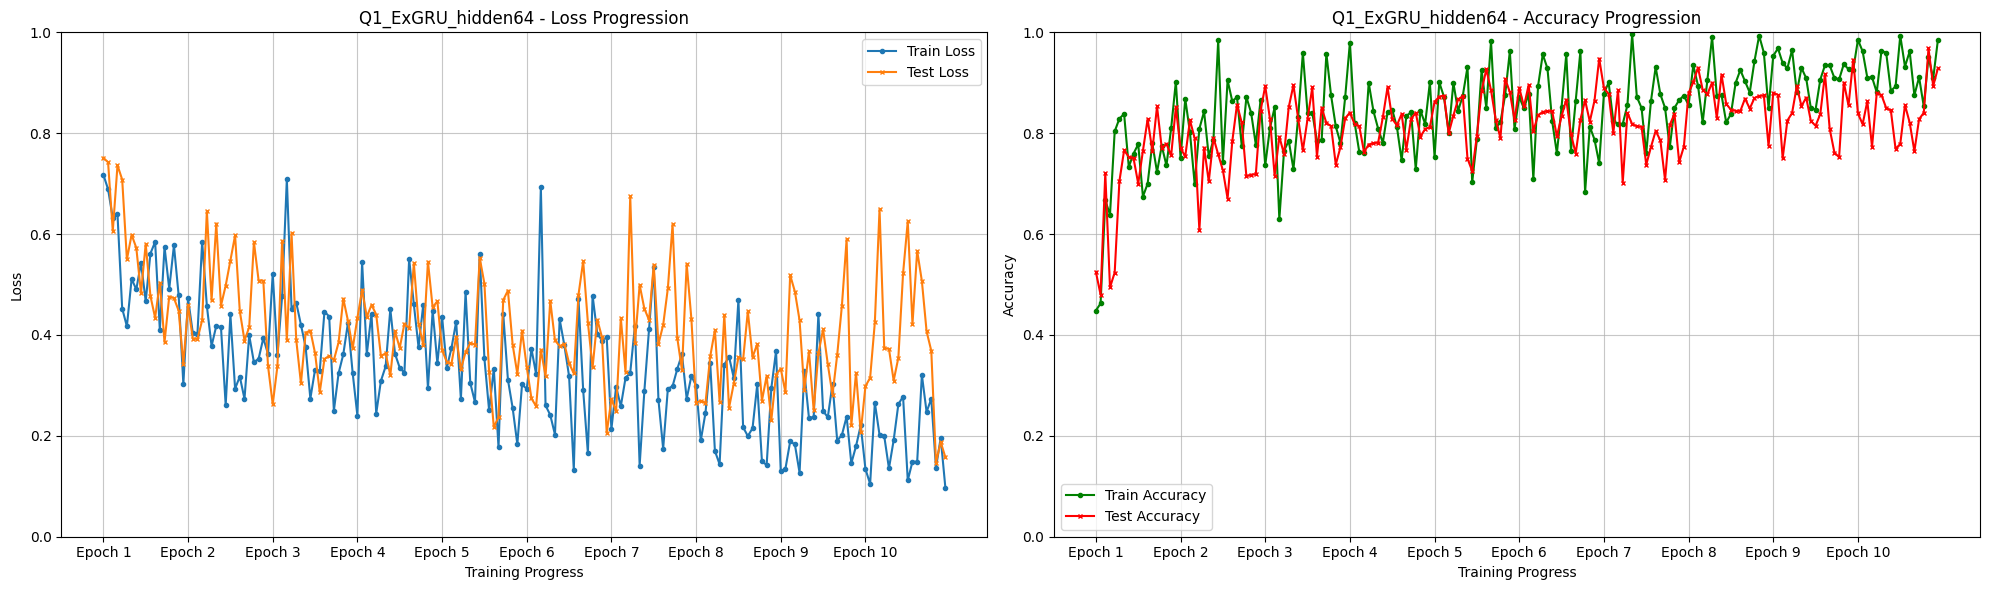

Running model: Q1_ExRNN_hidden128
Epoch [1/10] | Step [938/938] | Train Loss: 0.6855 | Test Loss: 0.6842 | Train Acc: 0.5473 | Test Acc: 0.5610
Epoch [2/10] | Step [938/938] | Train Loss: 0.7308 | Test Loss: 0.7080 | Train Acc: 0.3440 | Test Acc: 0.4895
Epoch [3/10] | Step [938/938] | Train Loss: 0.6740 | Test Loss: 0.7099 | Train Acc: 0.5595 | Test Acc: 0.4846
Epoch [4/10] | Step [938/938] | Train Loss: 0.7053 | Test Loss: 0.6912 | Train Acc: 0.3994 | Test Acc: 0.6472
Epoch [5/10] | Step [938/938] | Train Loss: 0.6777 | Test Loss: 0.6805 | Train Acc: 0.5589 | Test Acc: 0.6111
Epoch [6/10] | Step [938/938] | Train Loss: 0.6248 | Test Loss: 0.6806 | Train Acc: 0.8458 | Test Acc: 0.6217
Epoch [7/10] | Step [938/938] | Train Loss: 0.7142 | Test Loss: 0.7071 | Train Acc: 0.4010 | Test Acc: 0.4713
Epoch [8/10] | Step [938/938] | Train Loss: 0.7874 | Test Loss: 0.6608 | Train Acc: 0.3807 | Test Acc: 0.6055
Epoch [9/10] | Step [938/938] | Train Loss: 0.6482 | Test Loss: 0.6813 | Train Acc: 0.

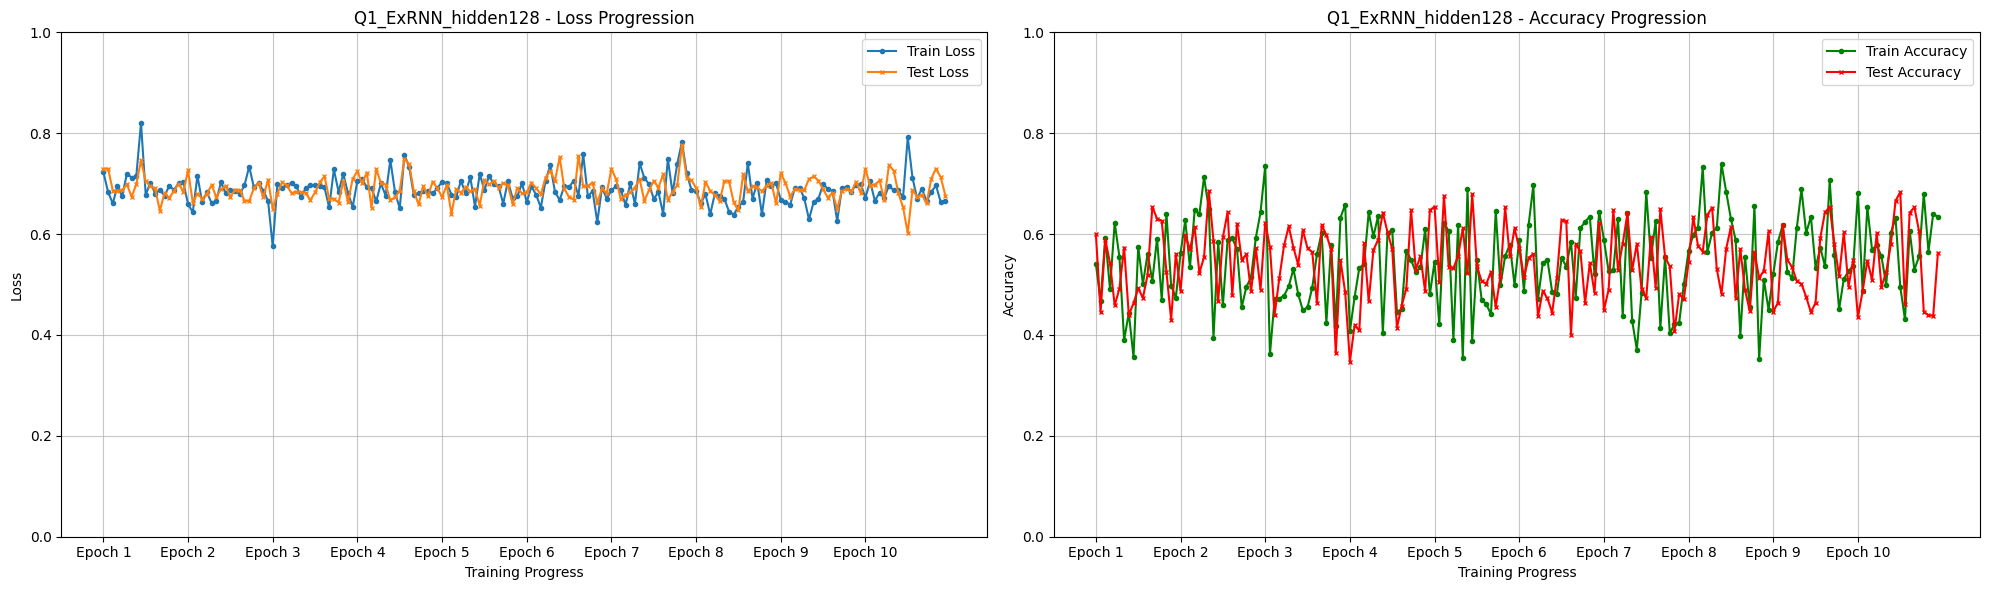

Running model: Q1_ExGRU_hidden128
Epoch [1/10] | Step [938/938] | Train Loss: 0.4208 | Test Loss: 0.5527 | Train Acc: 0.7591 | Test Acc: 0.7079
Epoch [2/10] | Step [938/938] | Train Loss: 0.3834 | Test Loss: 0.5724 | Train Acc: 0.8074 | Test Acc: 0.7449
Epoch [3/10] | Step [938/938] | Train Loss: 0.3620 | Test Loss: 0.2198 | Train Acc: 0.8100 | Test Acc: 0.9290
Epoch [4/10] | Step [938/938] | Train Loss: 0.2034 | Test Loss: 0.4523 | Train Acc: 0.9218 | Test Acc: 0.8135
Epoch [5/10] | Step [938/938] | Train Loss: 0.3130 | Test Loss: 0.2051 | Train Acc: 0.8730 | Test Acc: 0.8938
Epoch [6/10] | Step [938/938] | Train Loss: 0.3161 | Test Loss: 0.2600 | Train Acc: 0.8753 | Test Acc: 0.8802
Epoch [7/10] | Step [938/938] | Train Loss: 0.1868 | Test Loss: 0.5128 | Train Acc: 0.8729 | Test Acc: 0.8103
Epoch [8/10] | Step [938/938] | Train Loss: 0.1005 | Test Loss: 0.2909 | Train Acc: 0.9377 | Test Acc: 0.8450
Epoch [9/10] | Step [938/938] | Train Loss: 0.6279 | Test Loss: 0.5016 | Train Acc: 0.

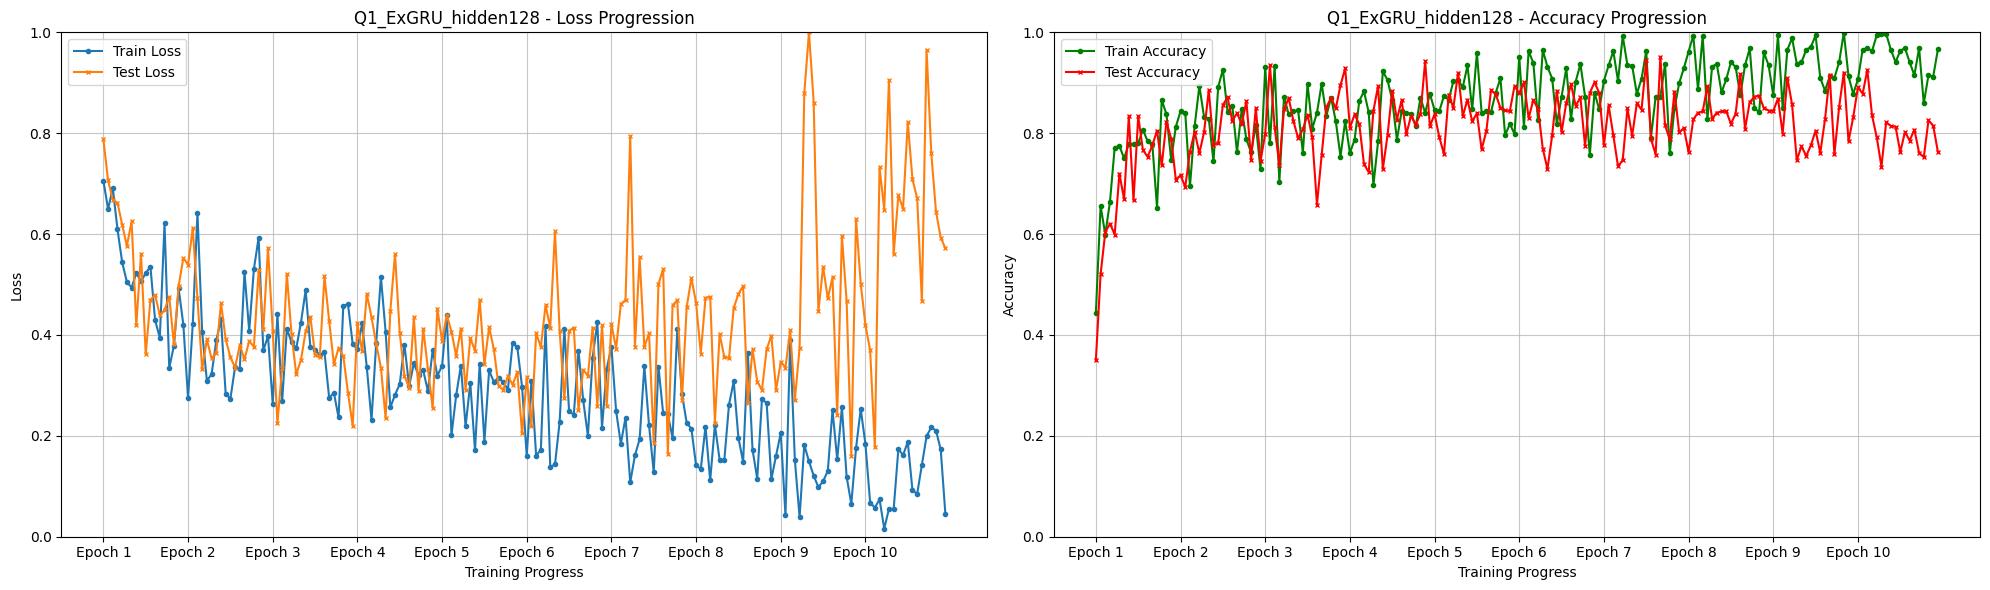

In [8]:
# Compare RNN vs GRU across hidden sizes
for hidden_size in [64, 128]:  # Sweep over small and large hidden states
    for model_class in [ExRNN, ExGRU]: # Sweep over RNN and GRU
        if model_class == ExRNN:
            use_RNN = True
        elif model_class == ExGRU:
            use_RNN = False
        model_name = f"Q1_{model_class.__name__}_hidden{hidden_size}"
        print("=" * 110)
        print(f"Running model: {model_name}")

        model = model_class(input_size, output_size, hidden_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        log_loss = train_model(
            model, model_name, train_dataset, test_dataset,
            num_words, criterion, optimizer, run_recurrent=True, use_RNN=use_RNN, use_MLP=False, atten_size=0
        )
        plot_losses_and_accuracy(log_loss, model_name)

#### Experimental Results Summary (TO-REDO)

From the training logs, we observe dramatic differences between RNN and GRU performance:

**Key Findings:**
1. **GRU vastly outperforms RNN**: GRU achieves ~90% test accuracy vs RNN's ~60%
2. **GRU converges much faster**: Reaches high accuracy by epoch 2-3
3. **Overfitting patterns differ**: GRU shows more overfitting with larger hidden size
4. **RNN struggles with learning**: Shows minimal improvement across epochs

##### Why GRU Outperforms RNN

1. **Gradient Flow**: GRU's gating mechanisms create shortcuts for gradients, preventing vanishing gradient problems that plague simple RNNs in long sequences (100 words)

2. **Selective Memory**: The reset gate (r) and update gate (z) allow GRU to:
   - Forget irrelevant past information (reset gate)
   - Selectively update hidden state (update gate)
   - Maintain long-term dependencies crucial for sentiment analysis

3. **Adaptive Learning**: GRU can learn when to keep vs. update information, while RNN blindly updates everything with tanh

##### Effect of Hidden State Size

- **RNN (64→128)**: Minimal change (~60% accuracy for both), suggesting the architecture itself is the bottleneck
- **GRU (64→128)**: 
  - Train accuracy increases (81%→91%)
  - Test accuracy remains similar (~90%)
  - Larger gap indicates overfitting with more parameters

#### Test Custom Reviews
the text reviews used for testing the models and their labels are set in the `loader.py` file.

In [9]:
# Test custom reviews demonstrating RNN vs GRU differences
import torch

# Define the models and their configurations
model_configs = [
    {"class": ExRNN, "hidden_size": 128, "name": "RNN_128"},
    {"class": ExGRU, "hidden_size": 128, "name": "GRU_128"},
]

# Load the trained models
loaded_models = {}
for config in model_configs:
    model_path = f"models/Q1_{config['class'].__name__}_hidden{config['hidden_size']}.pth"
    
    try:
        model = config["class"](input_size, output_size, config["hidden_size"])
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        loaded_models[config["name"]] = model
        print(f"Loaded: {model_path}")
    except FileNotFoundError:
        print(f"Model not found: {model_path} - Please check if training completed")
    except Exception as e:
        print(f"Error loading {model_path}: {e}")

# Make sure we have both models loaded
if "RNN_128" not in loaded_models or "GRU_128" not in loaded_models:
    print("Error: Both models need to be trained first!")
else:
    # 1) Load only the custom reviews
    _, custom_test_loader, num_words, _ = ld.get_data_set(batch_size=batch_size, toy=True)
    
    # 2) Extract the single batch containing all custom reviews
    labels, reviews, reviews_text = next(iter(custom_test_loader))
    
    # Verify we got all custom reviews
    print(f"\nLoaded {len(reviews_text)} reviews from custom test set")
    if len(reviews_text) != len(ld.my_test_texts):
        print(f"WARNING: Expected {len(ld.my_test_texts)} reviews but got {len(reviews_text)}")
    else:
        print("All custom reviews loaded successfully")
    
    # 3) For each model, run the full recurrence and collect logits
    model_logits = {}
    with torch.no_grad():
        for name, model in loaded_models.items():
            model.eval()
            hidden = model.init_hidden(reviews.size(0))
            for t in range(num_words):
                logits, hidden = model(reviews[:, t, :], hidden)
            model_logits[name] = logits

    # 4) Softmax to get probabilities
    model_probs = {
        name: torch.softmax(logits, dim=1).cpu()
        for name, logits in model_logits.items()
    }
    
    # 5) Analyze results
    print(f"\nAnalyzing {len(reviews_text)} custom reviews:")
    print("=" * 80)
    
    total = len(reviews_text)
    correct_counts = {"GRU_128": 0, "RNN_128": 0}
    
    for i, text in enumerate(reviews_text):
        true_label_idx = labels[i].argmax().item()
        true_label = "positive" if true_label_idx == 0 else "negative"
        print("-" * 80)
        print(f"Review #{i+1}:")
        print(f"Text: {' '.join(text[:20])}{'...' if len(text) > 20 else ''}")
        print(f"True label: {true_label}")
        
        for model_name in ["GRU_128", "RNN_128"]:
            probs = model_probs[model_name][i]
            pos_prob, neg_prob = probs.tolist()
            pred_label = "positive" if pos_prob > neg_prob else "negative"
            is_correct = (pred_label == true_label)
            correct_counts[model_name] += int(is_correct)
            print(f"{model_name}: pos={pos_prob:.3f}, neg={neg_prob:.3f} → {pred_label} {'✓' if is_correct else '✗'}")


    # 6) Summary statistics
    print("\n" + "=" * 80)
    print("SUMMARY:")
    for model_name in ["GRU_128", "RNN_128"]:
        acc = correct_counts[model_name] / total
        print(f"  {model_name}: {correct_counts[model_name]}/{total} correct ({acc:.1%})")

Loaded: models/Q1_ExRNN_hidden128.pth
Loaded: models/Q1_ExGRU_hidden128.pth

Loaded 18 reviews from custom test set
All custom reviews loaded successfully

Analyzing 18 custom reviews:
--------------------------------------------------------------------------------
Review #1:
Text: this movie is very very bad the worst movie
True label: negative
GRU_128: pos=0.000, neg=1.000 → negative ✓
RNN_128: pos=0.444, neg=0.556 → negative ✓
--------------------------------------------------------------------------------
Review #2:
Text: this movie is so great
True label: positive
GRU_128: pos=0.994, neg=0.006 → positive ✓
RNN_128: pos=0.444, neg=0.556 → negative ✗
--------------------------------------------------------------------------------
Review #3:
Text: i really liked the fish and animations the anther casting was not so good
True label: positive
GRU_128: pos=0.945, neg=0.055 → positive ✓
RNN_128: pos=0.444, neg=0.556 → negative ✗
-----------------------------------------------------------

#### Custom Review Analysis

TODO

### 2.
In a second experiment you will process each word by a small `MLP` to obtain the 2-class predictions (no softmax in this stage) over each word, which we term “*sub prediction scores*”, and then sum up all these two-dimensional vectors to obtain a final prediction.

Where will you apply the softmax - before or after summing these terms? (explain your answer).

Note that this averaging allows us to handle data of variable length.
Aim for FC architecture that achieves a low test loss, and summarize it in your report.

**Error analysis:**
Since this model gives a classification per word, we want to analyze its performance. Create four test reviews achieving the four scenarios: 
- true positive (TP), 
- false positive (FP), 
- true negative (TN), 
- and false negative (FN).

For each example, print a table of pairs of words and its sub prediction score (`reviews_text` and `sub_score` in the code).

Come up with an explanation of why the errors may have happened.

To conduct this experiment you are welcome to write your own test reviews in loader.py in the `my_test_texts`list.
  
**Add to your PDF the line where you apply global average pooling to get the final output.**  

#### MLP Class Implementation

- input: word (string)

- output: [positive prob, negative prob] for each word in a sentence

Softmax is a non-linear operation that transforms a vector into a probability distribution.
If we apply softmax before summing - that is, to each word's output — we would get a probability distribution per word, and then summing these would not preserve a valid probability interpretation at the sentence level.

In [10]:
# ============================== Lior ==============================
# MLP for question 2
class ExMLP(nn.Module):
    """Per-word MLP → 2-logit vector."""
    def __init__(self, in_dim=embedding_size, hidden=hidden_size, out_dim=output_size):
        super().__init__()
        # two simple linear layers for ReLU
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim)
        )

    def forward(self, x):
        """
        x : (batch, num_words, in_dim)
        returns (batch, 2) logits per sentence
        """
        subscores = self.mlp(x) # calculate [pos. prob,neg. prob] for each word in sentence via using 2 layers and ReLU
        summed_logits = torch.sum(subscores,dim=1) # calculate sum for pos. prob and neg. prob like it was mentioned in Q2
        output = torch.nn.functional.softmax(summed_logits, dim=1) # calculate final prediction by using softmax
        return output, subscores
# ============================== ==== ==============================


#### Train and test the `MLP` model

Running model: Q2_ExMLP
Epoch [1/10] | Step [938/938] | Train Loss: 0.9184 | Test Loss: 0.8696 | Train Acc: 0.3948 | Test Acc: 0.4437
Epoch [2/10] | Step [938/938] | Train Loss: 0.8655 | Test Loss: 0.8333 | Train Acc: 0.4477 | Test Acc: 0.4800
Epoch [3/10] | Step [938/938] | Train Loss: 0.7541 | Test Loss: 0.9145 | Train Acc: 0.5592 | Test Acc: 0.3988
Epoch [4/10] | Step [938/938] | Train Loss: 0.8784 | Test Loss: 0.7933 | Train Acc: 0.4349 | Test Acc: 0.5200
Epoch [5/10] | Step [938/938] | Train Loss: 0.8006 | Test Loss: 0.8540 | Train Acc: 0.5127 | Test Acc: 0.4592
Epoch [6/10] | Step [938/938] | Train Loss: 0.4739 | Test Loss: 0.8275 | Train Acc: 0.8394 | Test Acc: 0.4858
Epoch [7/10] | Step [938/938] | Train Loss: 0.8226 | Test Loss: 0.8957 | Train Acc: 0.4906 | Test Acc: 0.4176
Epoch [8/10] | Step [938/938] | Train Loss: 0.8779 | Test Loss: 0.8563 | Train Acc: 0.4354 | Test Acc: 0.4570
Epoch [9/10] | Step [938/938] | Train Loss: 0.8641 | Test Loss: 0.7519 | Train Acc: 0.4492 | Tes

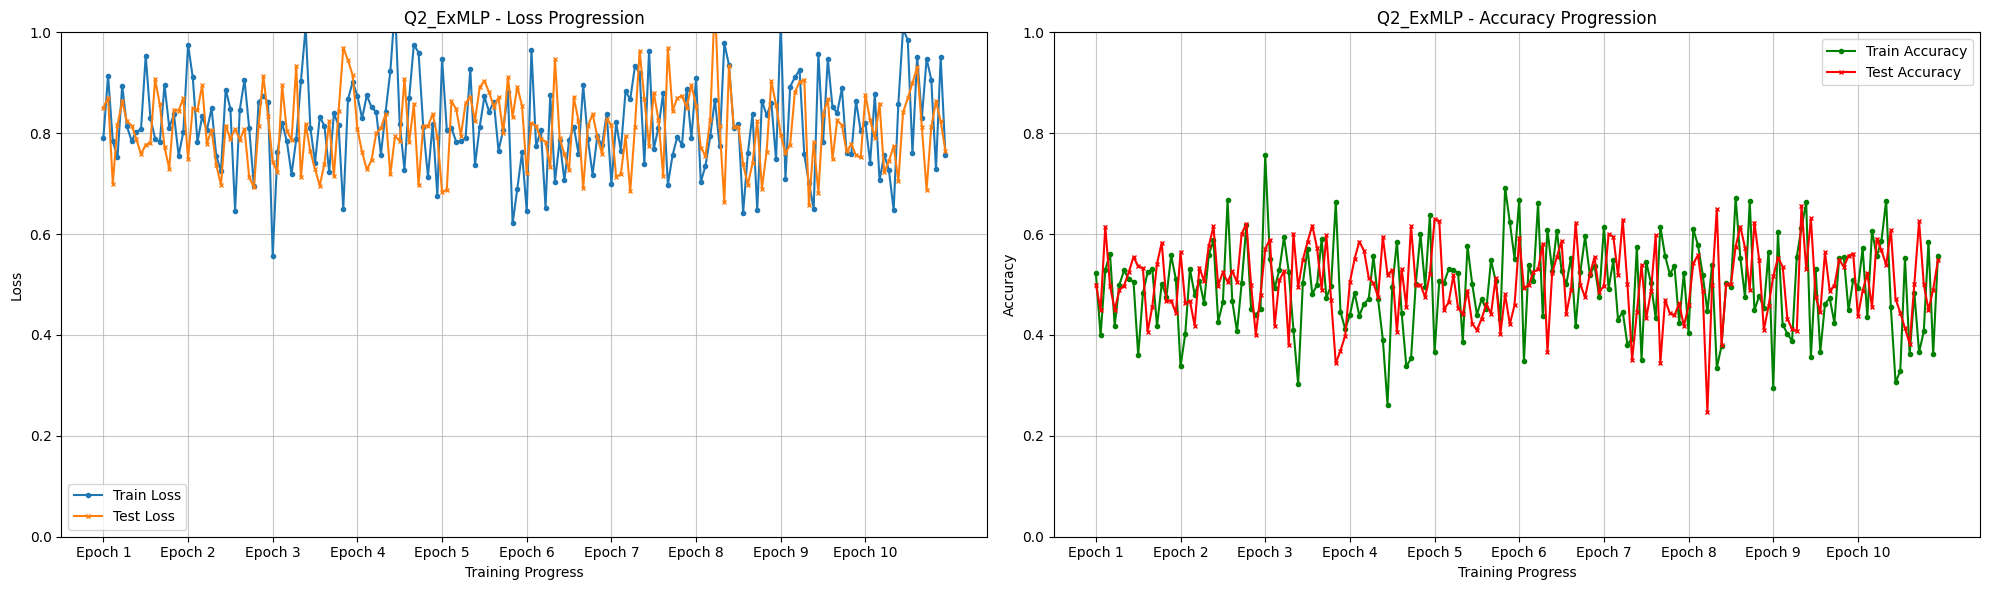

In [11]:
# ============================== Lior ==============================
# create a new MLP model
model_name = f"Q2_{ExMLP.__name__}"
print("=" * 110)
print(f"Running model: {model_name}")
model = ExMLP(embedding_size, hidden_size, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# calculate and plot log losses
log_loss = train_model(
            model,
            model_name,
            train_dataset,
            test_dataset,
            num_words,
            criterion,
            optimizer,
            run_recurrent = False,
            use_RNN = False,
            use_MLP=True,
            atten_size=0
            )

plot_losses_and_accuracy(log_loss, model_name)
# ============================== ==== ==============================

#### Testing `TP`, `FP`, `TN`, `FN` examples

In [12]:
import torch

my_test_texts = [
    ("This was a wonderful movie with great actors", [1, 0]),  # TP
    ("This movie was boring and disappointing",      [0, 1]),  # TN
    ("Great amazing beautiful trash",                [0, 1]),  # FP
    ("Awful stupid ugly masterpiece",                [1, 0])   # FN
]

model.eval() # test model
with torch.no_grad():
    for text, label in my_test_texts:
        tokens        = tokinize(text)
        review_tensor = preprocess_review(text).to(device)  # (1, 100, emb_dim)

        sent_logits, word_logits = model(review_tensor)  # word_logits: (1,100,2)
        probs = torch.softmax(sent_logits, dim=1)         # (1,2)
        pred  = probs.argmax(dim=1).item()                # 0/1
        true  = torch.tensor(label).argmax().item()       # 0/1
        print("-" * 80)
        print("Text:", text)
        print("Prediction:", "Positive" if pred == 0 else "Negative")
        print("True label:", "Positive" if true == 0 else "Negative")

        print("Per-word sub-scores (logits):")
        for word, logits in zip(tokens, word_logits[0, :len(tokens)]):
            pos_logit, neg_logit = logits.cpu().tolist()
            print(f"{word:<15}: pos={pos_logit:6.2f}  neg={neg_logit:6.2f}")


--------------------------------------------------------------------------------
Text: This was a wonderful movie with great actors
Prediction: Negative
True label: Positive
Per-word sub-scores (logits):
this           : pos= -1.10  neg=  1.09
was            : pos= -1.12  neg=  0.87
wonderful      : pos= -0.57  neg=  0.44
movie          : pos= -0.70  neg=  0.50
with           : pos= -0.97  neg=  0.91
great          : pos= -0.93  neg=  0.75
actors         : pos= -0.61  neg=  0.53
--------------------------------------------------------------------------------
Text: This movie was boring and disappointing
Prediction: Negative
True label: Negative
Per-word sub-scores (logits):
this           : pos= -1.10  neg=  1.09
movie          : pos= -0.70  neg=  0.50
was            : pos= -1.12  neg=  0.87
boring         : pos= -0.48  neg=  0.48
and            : pos= -1.11  neg=  1.08
disappointing  : pos= -0.61  neg=  0.75
-----------------------------------------------------------------------------

#### Results explanation: (TO-REDO)


(TP) Example 1: correct prediction

(TN) Example 2: correct prediction

(FP) Example 3: incorrect prediction. The prediction is positive, but should be negative.

Here are several strongly positive words — "great", "amazing", "beautiful" — each contributing very high positive logits (+20, +29, +25).
The word "trash" is the only negative word, with a very strong negative score (pos=-23.76, neg=+23.00), but it appears at the end, and is outnumbered by three positive words.
The main reason for failure is that the model naively averages per-word sentiment. That is why it ends up interpreting the sentence as a clearly positive review due to the majority of strong positive terms.

(FN) Example 4: incorrect prediction.The prediction is negative, but should be positive.

This sentence ends with the word "masterpiece", a strong positive word (pos=+9.5), but the rest of the words — "awful", "stupid", "ugly" — carry very strong negative scores. The average sentiment is strongly negative.
Since the majority of the words are negative, the summed logits make the final prediction negative.


Finally, the MLP model lacks the semantic understanding of sarcasm or juxtaposition. Sum calculation approach does not work when one word with a small weight changes sentence meaning dramatically.

### 3.
Write a *restricted* self-attention layer which queries every word with its closest 5 words on each side (using torch **roll** and **padding** of size 5), add a positional encoding.

This layer should have a single head and learnable query, key and value matrices. 

You can use the incomplete code in ExLRestSelfAtten to implement this layer or use your own code. This code can use torch.roll to shift the text right and left as well as torch.pad to handle the boundaries.

**Attach the code of this layer into your PDF, as well as the lines where you compute the attention scores using query and keys.**   

### `ExLRestSelfAtten` class Implementation

In [13]:
# Special matrix multipication layer (like torch.Linear but can operate on arbitrary sized
# tensors and considers its last two indices as the matrix.)

class MatMul(nn.Module):
    def __init__(self, in_channels, out_channels, use_bias = True):
        super(MatMul, self).__init__()
        self.matrix = torch.nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(in_channels,out_channels)), requires_grad=True)
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros(1,1,out_channels), requires_grad=True)

        self.use_bias = use_bias

    def forward(self, x):        
        x = torch.matmul(x,self.matrix) 
        if self.use_bias:
            x = x+ self.bias 
        return x

class ExLRestSelfAtten(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, atten_size=5):
        super(ExLRestSelfAtten, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.atten_size = atten_size
        self.sqrt_hidden_size = np.sqrt(float(hidden_size))
        self.ReLU = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(2)
        
        # Token-wise MLP + Restricted Attention network implementation

        self.layer1 = MatMul(input_size,hidden_size)
        self.W_q = MatMul(hidden_size, hidden_size, use_bias=False)
        # rest ...
        self.W_k = MatMul(hidden_size, hidden_size, use_bias=False)
        self.W_v = MatMul(hidden_size, hidden_size, use_bias=False)
        self.classifier = nn.Linear(hidden_size, output_size)  # final classifier layer
        self.positional_encoding = nn.Parameter(torch.zeros(1, MAX_LENGTH, hidden_size), requires_grad=True)



    def name(self):
        return "MLP_atten"

    def forward(self, x):

        # Token-wise MLP + Restricted Attention network implementation

        x = self.layer1(x)
        x = self.ReLU(x)
        x = x + self.positional_encoding[:, :x.size(1), :]


        # generating x in offsets between -atten_size and atten_size 
        # with zero padding at the ends

        padded = pad(x,(0,0,self.atten_size,self.atten_size,0,0))


        x_nei = []
        for k in range(-self.atten_size, self.atten_size+1):

            x_nei.append(torch.roll(padded, k, 1))

        x_nei = torch.stack(x_nei,2)
        x_nei = x_nei[:,self.atten_size:-self.atten_size,:]

        # x_nei has an additional axis that corresponds to the offset

        # Applying attention layer

        # query = ...
        # keys = ...
        # vals = ...
        query = self.W_q(x)                             # (B, T, H)
        keys  = self.W_k(x_nei)                         # (B, T, 2k+1, H)
        vals  = self.W_v(x_nei)                         # (B, T, 2k+1, H)

        # Compute attention scores
        # scores = (q ⋅ k^T) / sqrt(H)
        query = query.unsqueeze(2)                      # (B, T, 1, H)
        scores = torch.sum(query * keys, dim=-1)        # (B, T, 2k+1)
        scores = scores / self.sqrt_hidden_size

        # Apply softmax over neighborhood axis
        atten_weights = self.softmax(scores)            # (B, T, 2k+1)

        # Weighted sum of values
        attended = torch.sum(atten_weights.unsqueeze(-1) * vals, dim=2)  # (B, T, H)

        # Final classification per word
        sub_scores = self.classifier(attended)          # (B, T, 2)
        return sub_scores, atten_weights

        return x, atten_weights

#### Train and test the `ExLRestSelfAtten` model

Running model: Q3_ExLRestSelfAtten_atten5
Epoch [1/10] | Step [938/938] | Train Loss: 0.2614 | Test Loss: 0.6936 | Train Acc: 0.8662 | Test Acc: 0.6526
Epoch [2/10] | Step [938/938] | Train Loss: 0.2603 | Test Loss: 0.5007 | Train Acc: 0.8687 | Test Acc: 0.7857
Epoch [3/10] | Step [938/938] | Train Loss: 0.3104 | Test Loss: 0.2250 | Train Acc: 0.8687 | Test Acc: 0.8947
Epoch [4/10] | Step [938/938] | Train Loss: 0.6476 | Test Loss: 0.4389 | Train Acc: 0.5886 | Test Acc: 0.7486
Epoch [5/10] | Step [938/938] | Train Loss: 0.2702 | Test Loss: 0.3931 | Train Acc: 0.9256 | Test Acc: 0.7987
Epoch [6/10] | Step [938/938] | Train Loss: 0.3445 | Test Loss: 0.3528 | Train Acc: 0.8208 | Test Acc: 0.8594
Epoch [7/10] | Step [938/938] | Train Loss: 0.3736 | Test Loss: 0.4742 | Train Acc: 0.8271 | Test Acc: 0.8180
Epoch [8/10] | Step [938/938] | Train Loss: 0.2298 | Test Loss: 0.2644 | Train Acc: 0.8769 | Test Acc: 0.9000
Epoch [9/10] | Step [938/938] | Train Loss: 0.1364 | Test Loss: 0.3423 | Train

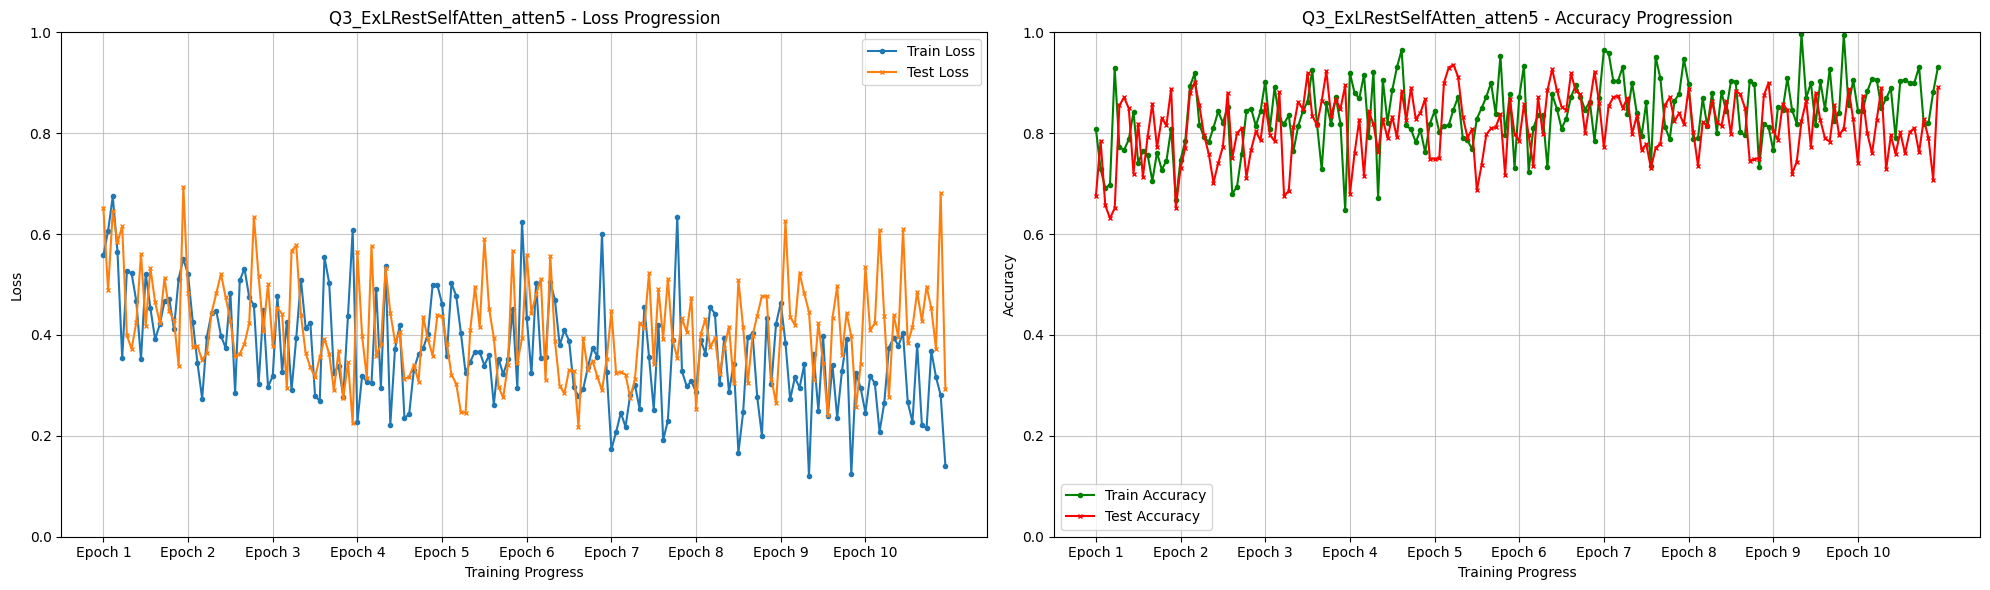

In [14]:
# create a new Self-Attention model
atten_size_global = 5

model_name = f"Q3_{ExLRestSelfAtten.__name__}_atten{atten_size_global}"
print("=" * 110)
print(f"Running model: {model_name}")
model = ExLRestSelfAtten(embedding_size, output_size, hidden_size, atten_size=atten_size_global)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# calculate and plot log losses
log_loss = train_model(
    model,
    model_name,
    train_dataset,
    test_dataset,
    num_words,
    criterion,
    optimizer,
    run_recurrent = False,
    use_RNN = False,
    use_MLP = False,
    atten_size = atten_size_global
)

plot_losses_and_accuracy(log_loss, model_name)
# ============================== ==== ==============================


#### Testing `TP`, `FP`, `TN`, `FN` examples from Q2

In [15]:
# Evaluate Self-Attention model on TP/FP/TN/FN

model.eval()
with torch.no_grad():
    for text, label in my_test_texts:
        tokens = tokinize(text)
        review_tensor = preprocess_review(text).to(device)  # (1, 100, emb_dim)

        sub_scores, atten_weights = model(review_tensor)  # (1, 100, 2), (1, 100, 2k+1)
        summed_logits = torch.sum(sub_scores, dim=1)       # (1, 2)
        probs = torch.softmax(summed_logits, dim=1)        # (1, 2)
        pred = probs.argmax(dim=1).item()                  # 0/1
        true = torch.tensor(label).argmax().item()         # 0/1
        print("-" * 80)
        print("Text:", text)
        print("Prediction:", "Positive" if pred == 0 else "Negative")
        print("True label:", "Positive" if true == 0 else "Negative")

        print("\nPer-word sub-scores (logits):")
        for word, logits in zip(tokens, sub_scores[0, :len(tokens)]):
            pos_logit, neg_logit = logits.cpu().tolist()
            print(f"{word:<15}: pos={pos_logit:6.2f}  neg={neg_logit:6.2f}")

--------------------------------------------------------------------------------
Text: This was a wonderful movie with great actors
Prediction: Positive
True label: Positive

Per-word sub-scores (logits):
this           : pos= 23.54  neg=-26.65
was            : pos=  0.08  neg= -0.15
wonderful      : pos=  9.38  neg=-10.67
movie          : pos= 15.23  neg=-17.26
with           : pos= -0.70  neg=  0.74
great          : pos= 14.09  neg=-15.98
actors         : pos= -3.18  neg=  3.54
--------------------------------------------------------------------------------
Text: This movie was boring and disappointing
Prediction: Negative
True label: Negative

Per-word sub-scores (logits):
this           : pos=-17.86  neg= 20.10
movie          : pos=-18.10  neg= 20.40
was            : pos=-17.60  neg= 19.82
boring         : pos=-18.11  neg= 20.41
and            : pos=-12.75  neg= 14.26
disappointing  : pos=-18.11  neg= 20.40
---------------------------------------------------------------------------

### 4.
Finally, add this layer to the network architecture you used in Task 2 (before the sub prediction scores are computed) and repeat the experiments above, i.e., the four reviews (TP, TN, FP, FN).

Print the per word sub prediction scores and check whether they changed.

Explain the results (at least the improvement if you see one).

In addition, create a test review of your own where the context of a word changes given its neighboring word/s.

See if you can get the network in Task 2 to fail on this example, while the new (self-atten.) network succeeds.

Include the reviews, their per word scores and explanations in your report.

**We are expecting you to report and elaborate on every practical task in the pdf, with your own words and analysis of what you’ve done.**

**Include all the plots and everything that you think is crucial for us to understand your way of thinking into the pdf. Plots that wouldn’t be part of the pdf would cause a decrease in grade.**

**Note to add the elaborated code lines into your PDF for each task.**

## **Theoretical Questions:**

### 1.
Explain what type of a network architecture you will use to handle each of the following problems (e.g., many-to-many RNN, or a one-to-one convolution NN). Explain your reasoning.
   a. Speech recognition (audio to text)
   b. Answer questions
   c. Sentiment analysis
   d. Image classification
   e. Single word translation

### 2. Text-to-Image:

#### a.
Describe the architecture of a network that reads a sentence and generates an image based on the text. Do not address the question of how such a network is trained, just explain why its architecture should have the capacity to perform this task. Assume that the images come from a restricted class of images, e.g., faces, and can be encoded, and decoded, in a low-dimensional latent space.

#### b.
Assume an image is encoded using 4 latent codes that correspond to its four quadrants. Explain how an attention can be used to allow such a network to better support fine-grained descriptions in the input text, which refers to the different regions (top, bottom, left, right, sky, ground, etc.). Note that the architecture should be able to link text to specific image latent code.

### 3. CNNs:


#### a.
Assume an 128X128x1 input image is inputted to the following architecture :

- conv(kernal_size=3,stride=2,padding=0)

- conv(kernal_size=5,stride=1,padding=2)

- conv(kernal_size=3,stride=1,padding=1)

- conv(kernal_size=5,stride=2,padding=0)

where padding=0 is equivalent to ‘valid’. What would be the output size of the response map produced by this network?

#### b.
What would be the size of the receptive field of each neuron in the final layer (consider center neurons which are not affected by the padding).

### 4.
Transformer network:

Show and explain why a transformer composed solely of successive self-attention layers and fully connected (feed-forward) layers acts as a permutation-invariant function on its input tokens \- i.e., its output is unchanged if the tokens are reordered. Then show that once positional encodings are added, this permutation invariance no longer holds.

**Submission Guidelines:**

The submission is in **pairs.**   
Please submit a single pdf named ex2\_ID1\_ID2\_answers.pdf in the dedicated submission box. This file should contain your answers to the theoretical part, the figures/text for the practical part, and the code you were asked to add.  
Separately, please submit your code files compressed as zip file, named “ex2\_ID1\_ID2.zip”, the dedicated submission box. Furthermore, include in this compress file a README with your names and cse usernames  
Note: you must register as a pair in **both** the submission boxes. Please avoid inconsistencies.  
Please write readable code, with documentation where needed. The code will also be checked manually.  
Late submission \- 10 points reduction for each day. Submissions will not be accepted after 4 days.  
**Alone submissions \- only to the very few students that got explicit approval.**